In [1]:
import json

# preps in which 1st object has greater z value than 2nd
deeper_preps = [' behind ', ' inside ']

# 1st has lower z value
shallower_preps = [' outside ', ' front ', ' in front of ', ' against ']

In [2]:
with open('subset_data/region_graphs.json') as region_graph, open('subset_data/objects.json') as objects:
    data = json.load(region_graph)
    mini = json.load(objects)


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image as PIL_Image
import requests
from io import StringIO, BytesIO
from visual_genome import models, api, local, utils

In [4]:
annotated_regions = []

In [5]:
def get_image_data(id):
    """
    Get data about an image.
    """
    
    data = utils.retrieve_data('/api/v0/images/' + str(id))
    
    if 'detail' in data and data['detail'] == 'Not found.':
        return None
    image = utils.parse_image_data(data)

    return image

In [6]:
def get_object_details(name, details, idx):
    obj_to_add = [name,\
                      details[0],\
                      details[1],\
                      idx,\
                      details[2],\
                      details[3]
                     ]
    
    return obj_to_add

In [7]:
def plot_regions(img, regions):
    plt.imshow(img)
    ax = plt.gca()
    for region in regions:
        ax.add_patch(Rectangle((region['x'], region['y']),
                               region['width'],
                               region['height'],
                               fill=False,
                               edgecolor='red',
                               linewidth=3))
        ax.text(region['x'], region['y'], region['phrase'], style='italic', bbox={'facecolor':'white', 'alpha':0.7, 'pad':10})
    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.show()
        
def plot_deep_obj(img, deep_objs):
    plt.imshow(img)
    ax = plt.gca()
    for deep_object in deep_objs:
        ax.add_patch(Rectangle((deep_object[1], deep_object[2]),
                               deep_object[5],
                               deep_object[4],
                               fill=False,
                               edgecolor='green',
                               linewidth=3))
        ax.text(deep_object[1], deep_object[2] , deep_object[0], style='italic', bbox={'facecolor':'white', 'alpha':0.7, 'pad':10})
    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.show()
    
def plot_shallow_obj(img, shallow_objs):
    plt.imshow(img)
    ax = plt.gca()
    for shallow_object in shallow_objs:
        ax.add_patch(Rectangle((shallow_object[1], shallow_object[2]),
                               shallow_object[5],
                               shallow_object[4],
                               fill=False,
                               edgecolor='yellow',
                               linewidth=3))
        ax.text(shallow_object[1], shallow_object[2], shallow_object[0], style='italic', bbox={'facecolor':'white', 'alpha':0.7, 'pad':10})


    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.show()

In [11]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
def visualize_regions(to_annotate):
    for image_id in to_annotate.keys():
        image = get_image_data(image_id)
        print("Image Id: ",image_id)
        response = requests.get(image.url)
        img = PIL_Image.open(BytesIO(response.content))
        
        plt.imshow(img)
        ax = plt.gca()
        print("Region bounding boxes: ")
        plot_regions(img, to_annotate[image_id][0])
        
        print("Deep Object bounding boxes: ")
        plot_deep_obj(img, to_annotate[image_id][1])
        
        print("Shallow Object bounding boxes: ")
        plot_shallow_obj(img, to_annotate[image_id][2])


<Figure size 1332x756 with 0 Axes>

In [9]:
to_annotate = {}

for image, objs in zip(data, mini):
    wannabe_objetcs = {}
    for o in objs['objects']:
         wannabe_objetcs[o['names'][0]]=  (o['x'], o['y'], o['h'], o['w'])
    regions = image['regions']
    annotate_reg = []
    annotate_shallow = []
    annotate_deep = []
    for region in regions:
        region_added = False
        for word in deeper_preps:
            if word in region['phrase']:
                temp = sorted(region['synsets'], key=lambda k: k['entity_idx_start'], reverse=True)
                for idx, ele in enumerate(temp):
                    low_life = ele['entity_name'].lower()
                    if low_life in wannabe_objetcs.keys():
                        if not region_added:
                            annotate_reg.append(region)
                            region_added = True
                        obj_to_add = get_object_details(ele['entity_name'], wannabe_objetcs[low_life], idx)
                        annotate_deep.append(obj_to_add)
                        
                        if idx == 0 :
                            annotate_shallow.append(obj_to_add)
                        else :
                            annotate_deep.append(obj_to_add)
                        
                        super_string = ''
                        super_string += ele['entity_name'] + ';'
                        super_string += ' x = ' + str(wannabe_objetcs[low_life][0])
                        super_string += ', y = ' + str(wannabe_objetcs[low_life][1])
                        super_string += ', z = ' + str(idx)


        for word in shallower_preps:
            if word in region['phrase']:

                temp = sorted(region['synsets'], key=lambda k: k['entity_idx_start'])
                for idx, ele in enumerate(temp):
                    low_life = ele['entity_name'].lower()
                    if low_life in wannabe_objetcs:
                        obj_to_add = get_object_details(ele['entity_name'], wannabe_objetcs[low_life],idx)
                        if idx == 0 :
                            annotate_shallow.append(obj_to_add)
                        else :
                            annotate_deep.append(obj_to_add)
                        super_string = ''
                        super_string += ele['entity_name'] + ';'
                        super_string += ' x = ' + str(wannabe_objetcs[low_life][0])
                        super_string += ', y = ' + str(wannabe_objetcs[low_life][1])
                        super_string += ', z = ' + str(idx)

    for region in annotate_reg:
        key = region['image_id']
        if key not in to_annotate.keys():
            to_annotate[region['image_id']] = [annotate_reg, annotate_deep, annotate_shallow]


Image Id:  2
Region bounding boxes: 


/home/user/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


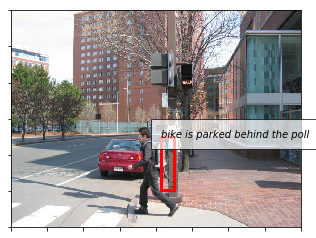

Deep Object bounding boxes: 


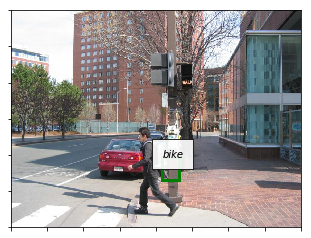

Shallow Object bounding boxes: 


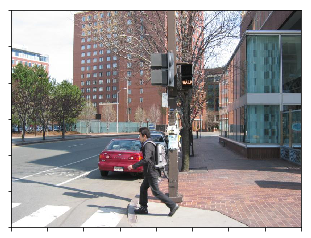

Image Id:  3
Region bounding boxes: 


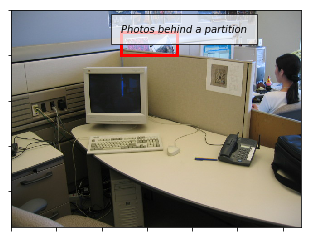

Deep Object bounding boxes: 


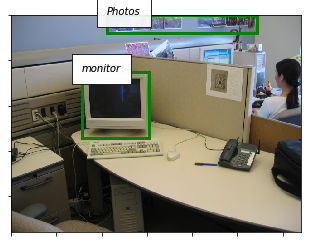

Shallow Object bounding boxes: 


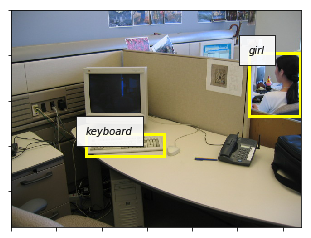

Image Id:  4
Region bounding boxes: 


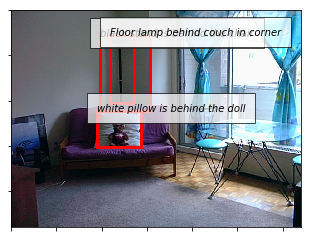

Deep Object bounding boxes: 


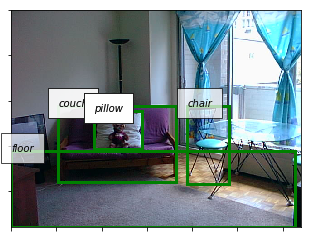

Shallow Object bounding boxes: 


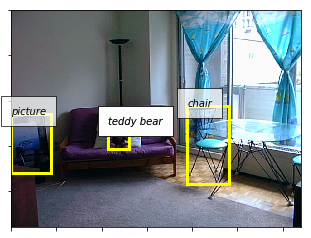

Image Id:  6
Region bounding boxes: 


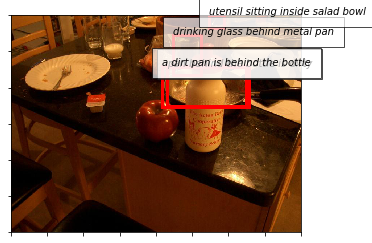

Deep Object bounding boxes: 


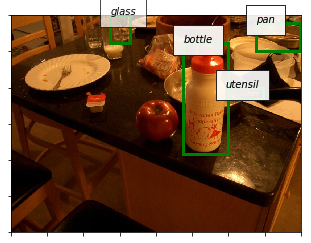

Shallow Object bounding boxes: 


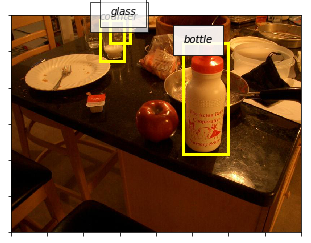

Image Id:  7
Region bounding boxes: 


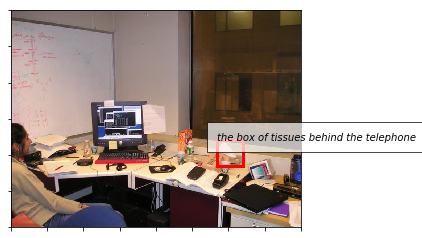

Deep Object bounding boxes: 


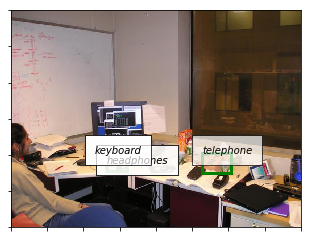

Shallow Object bounding boxes: 


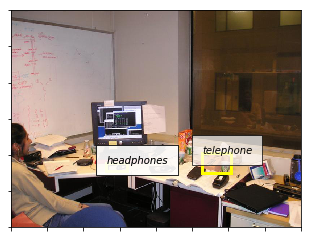

Image Id:  8
Region bounding boxes: 


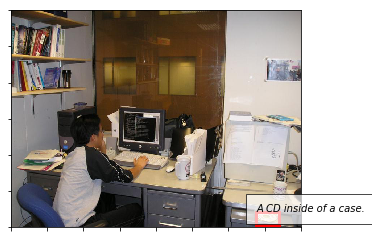

Deep Object bounding boxes: 


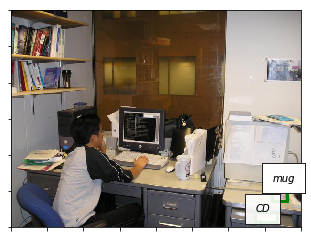

Shallow Object bounding boxes: 


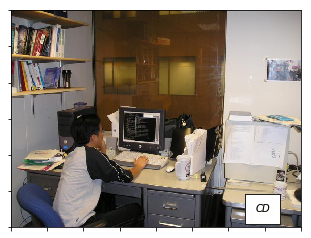

Image Id:  12
Region bounding boxes: 


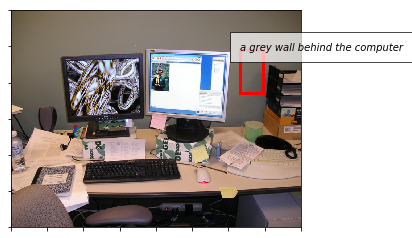

Deep Object bounding boxes: 


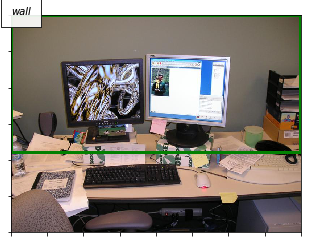

Shallow Object bounding boxes: 


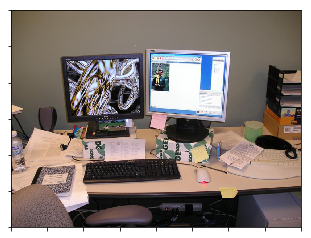

Image Id:  13
Region bounding boxes: 


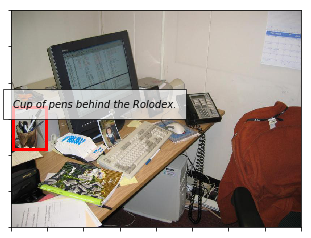

Deep Object bounding boxes: 


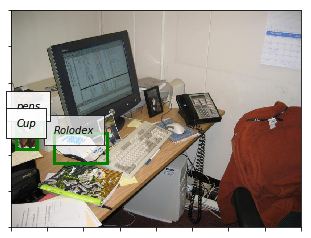

Shallow Object bounding boxes: 


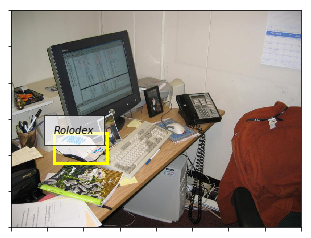

Image Id:  15
Region bounding boxes: 


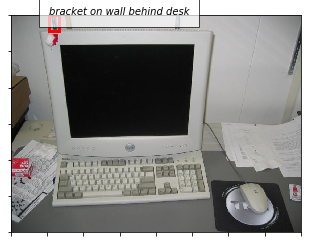

Deep Object bounding boxes: 


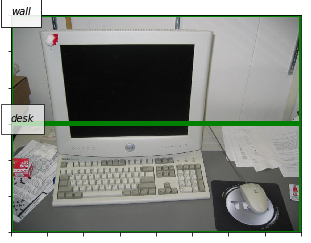

Shallow Object bounding boxes: 


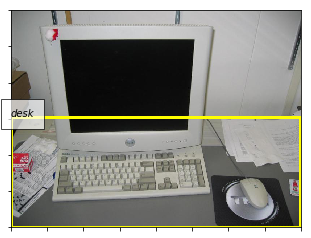

In [12]:
visualize_regions(to_annotate)        